# 0 Data Preprocessing

In [ ]:
/content/sample_data/README.md

NameError: ignored

## 0.0 Utility Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from itertools import cycle

## 0.1 Feature Selection
We only cares about the first 400 columns as our predictors, so we drop the remaining columns.

In [ ]:
raw_data = pd.read_csv("./movieReplicationSet.csv")
movie_ratings = raw_data.iloc[:,:400]

In [ ]:
movie_ratings

The Life of David Gale (2003)  Wing Commander (1999)  \
0                               NaN                    NaN   
1                               NaN                    NaN   
2                               NaN                    NaN   
3                               NaN                    NaN   
4                               NaN                    NaN   
...                             ...                    ...   
1092                            NaN                    NaN   
1093                            3.0                    4.0   
1094                            NaN                    NaN   
1095                            NaN                    NaN   
1096                            NaN                    NaN   

      Django Unchained (2012)  Alien (1979)  \
0                         4.0           NaN   
1                         1.5           NaN   
2                         NaN           NaN   
3                         2.0           NaN   
4                         3.5           NaN   
...                       ...           ...   
1092                      NaN           NaN   
1093                      NaN           NaN   
1094                      NaN           NaN   
1095                      NaN           NaN   
1096                      4.0           NaN   

      Indiana Jones and the Last Crusade (1989)  Snatch (2000)  \
0                                           3.0            NaN   
1                                           NaN            NaN   
2                                           NaN            NaN   
3                                           3.0            NaN   
4                                           0.5            NaN   
...                                         ...            ...   
1092                                        3.5            NaN   
1093                                        4.0            4.0   
1094                                        NaN            NaN   
1095                                        NaN            NaN   
1096                                        2.5            NaN   

      Rambo: First Blood Part II (1985)  Fargo (1996)  \
0                                   NaN           NaN   
1                                   NaN           NaN   
2                                   NaN           NaN   
3                                   NaN           NaN   
4                                   0.5           1.0   
...                                 ...           ...   
1092                                NaN           NaN   
1093                                2.5           NaN   
1094                                NaN           3.5   
1095                                NaN           NaN   
1096                                NaN           3.0   

      Let the Right One In (2008)  Black Swan (2010)  ...  X-Men 2 (2003)  \
0                             NaN                NaN  ...             NaN   
1                             NaN                NaN  ...             NaN   
2                             NaN                NaN  ...             NaN   
3                             NaN                4.0  ...             NaN   
4                             NaN                0.0  ...             2.5   
...                           ...                ...  ...             ...   
1092                          NaN                NaN  ...             NaN   
1093                          3.5                3.5  ...             4.0   
1094                          NaN                NaN  ...             NaN   
1095                          NaN                NaN  ...             NaN   
1096                          NaN                3.5  ...             NaN   

      The Usual Suspects (1995)  The Mask (1994)  Jaws (1975)  \
0                           NaN              NaN          4.0   
1                           NaN              NaN          NaN   
2                           NaN              NaN          NaN   
3                           3.0  

## 0.2 Data Preprocessing

Here we process the data, the final data format is as follows:


{

  movie_name:
  
  {

    (predictor, movie_name):{

      "predictor": dataframe
      ,"label": label
      }
    }

    
}

In [ ]:
from sklearn.impute import SimpleImputer
# Dealing with the missing values - imputing
def handle_missing_values(movie_data, imputer, parameter):
  imputer_obj = imputer(strategy = parameter)
  data_imputed = imputer_obj.fit_transform(movie_data)
  movie_data_imputed = pd.DataFrame(data_imputed)
  movie_data_imputed.columns = movie_data.columns
  movie_data_imputed.index = movie_data.index
  return movie_data_imputed


# Create data pairs for a specific movie
def create_data_pair_single(movie_data, target):
  movie_names = movie_data.columns
  data_bundle = {}
  for predictor in movie_names:
    if predictor != target:
      tmp = {}
      # Dropping the missing values
      dropped_movie_data = movie_data[[predictor, target]].dropna()
      tmp["predictor"] = dropped_movie_data[[predictor]]
      tmp["label"] = dropped_movie_data[target]
      data_bundle[(predictor,target)] = tmp

  return data_bundle


def create_data_pair(movie_data):
  data_bundle = {}
  for movie in movie_data.columns:
    data_bundle[movie] = create_data_pair_single(movie_data, movie)
  return data_bundle

# imputed_movie_ratings = handle_missing_values(movie_ratings, SimpleImputer, "mean")
# imputed_movie_ratings = handle_missing_values_drop(movie_data)
processed_data = create_data_pair(movie_ratings)

# Problem 1
For each of the 400 movies, use a simple linear regression model to predict the ratings. Use the ratings of the *other* 399 movies in the dataset to predict the ratings of each movie (that means you’ll have to build 399 models for each of the 400 movies). For each of the 400 movies, find the movie that predicts ratings the best. Then report the average COD of those 400 simple linear regression models. Please include a histogram of these 400 COD values and a table with the 10 movies that are most easily predicted from the ratings of a single other movie and the 10 movies that are hardest to predict from the ratings of a single other movie (and their associated COD values, as well as which movie ratings are the best predictor, so this table should have 3 columns).

## 1.0 Utility Functions


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Compute all COD for a single movie - Linear Regression Model
def compute_COD_single(data_bundle, target):
  training_data = data_bundle[target]
  model = LinearRegression()
  COD = []
  best_COD = -np.inf
  best_predictor = None

  for pair_key, data in training_data.items():
    model.fit(data["predictor"], data["label"])
    predictions = model.predict(data["predictor"])
    R2 = r2_score(data["label"], predictions)
    COD.append(R2)
    if R2 > best_COD:
      best_predictor = pair_key[0]
      best_COD = max(R2, best_COD)


  average_COD = np.mean(COD)
  return COD, average_COD, best_predictor, best_COD

# Find the best predictor and average COD for each movie
def find_best_predictor(process_data):
  best_predictor_mapping = {}
  average_COD_mapping = {}
  best_COD_mapping = {}
  COD_LIST_mapping = {}
  for movie in movie_ratings.columns:
    COD, average_COD, best_predictor, best_COD = compute_COD_single(processed_data, movie)
    best_predictor_mapping[movie] = best_predictor
    average_COD_mapping[movie] = average_COD
    best_COD_mapping[movie] = best_COD
    COD_LIST_mapping[movie] = COD

  return best_predictor_mapping, average_COD_mapping, best_COD_mapping, COD_LIST_mapping

## 1.1 Find the movie that predicts ratings the best.

In [ ]:
best_predictor_mapping, average_COD_mapping, best_COD_mapping, COD_LIST_mapping = find_best_predictor(processed_data)

In [ ]:
COD_LIST_mapping

{'The Life of David Gale (2003)': [0.36683347881987105,
  0.35017839115081895,
  0.11073136481430124,
  0.15520002987775028,
  0.25531152244898303,
  0.1436251124529434,
  0.2586250127605604,
  0.25832465639316937,
  0.101482742835177,
  0.06369844743352193,
  0.20480205846383503,
  0.09502777934011553,
  0.2974410914572352,
  0.075125091940632,
  0.2583871625499693,
  0.11879782798875738,
  0.14253334518913552,
  0.06045523389704488,
  0.23291360494765467,
  0.23544497877474935,
  0.17999834452683117,
  0.14213104543418187,
  0.1765679742118471,
  0.3203864096344038,
  0.39546676730034436,
  0.15454069638131418,
  0.438714657365848,
  0.46206731071886864,
  0.17448694617364635,
  0.15130548138046696,
  0.23187546171456175,
  0.237615135673388,
  0.16741288380213704,
  0.15157788306728792,
  0.10774017238120637,
  0.331347492820543,
  0.2363846718536775,
  0.15338697572129223,
  0.23090800777424092,
  0.11426049394006021,
  0.17505700876912078,
  0.15506372972751925,
  0.22396001699093

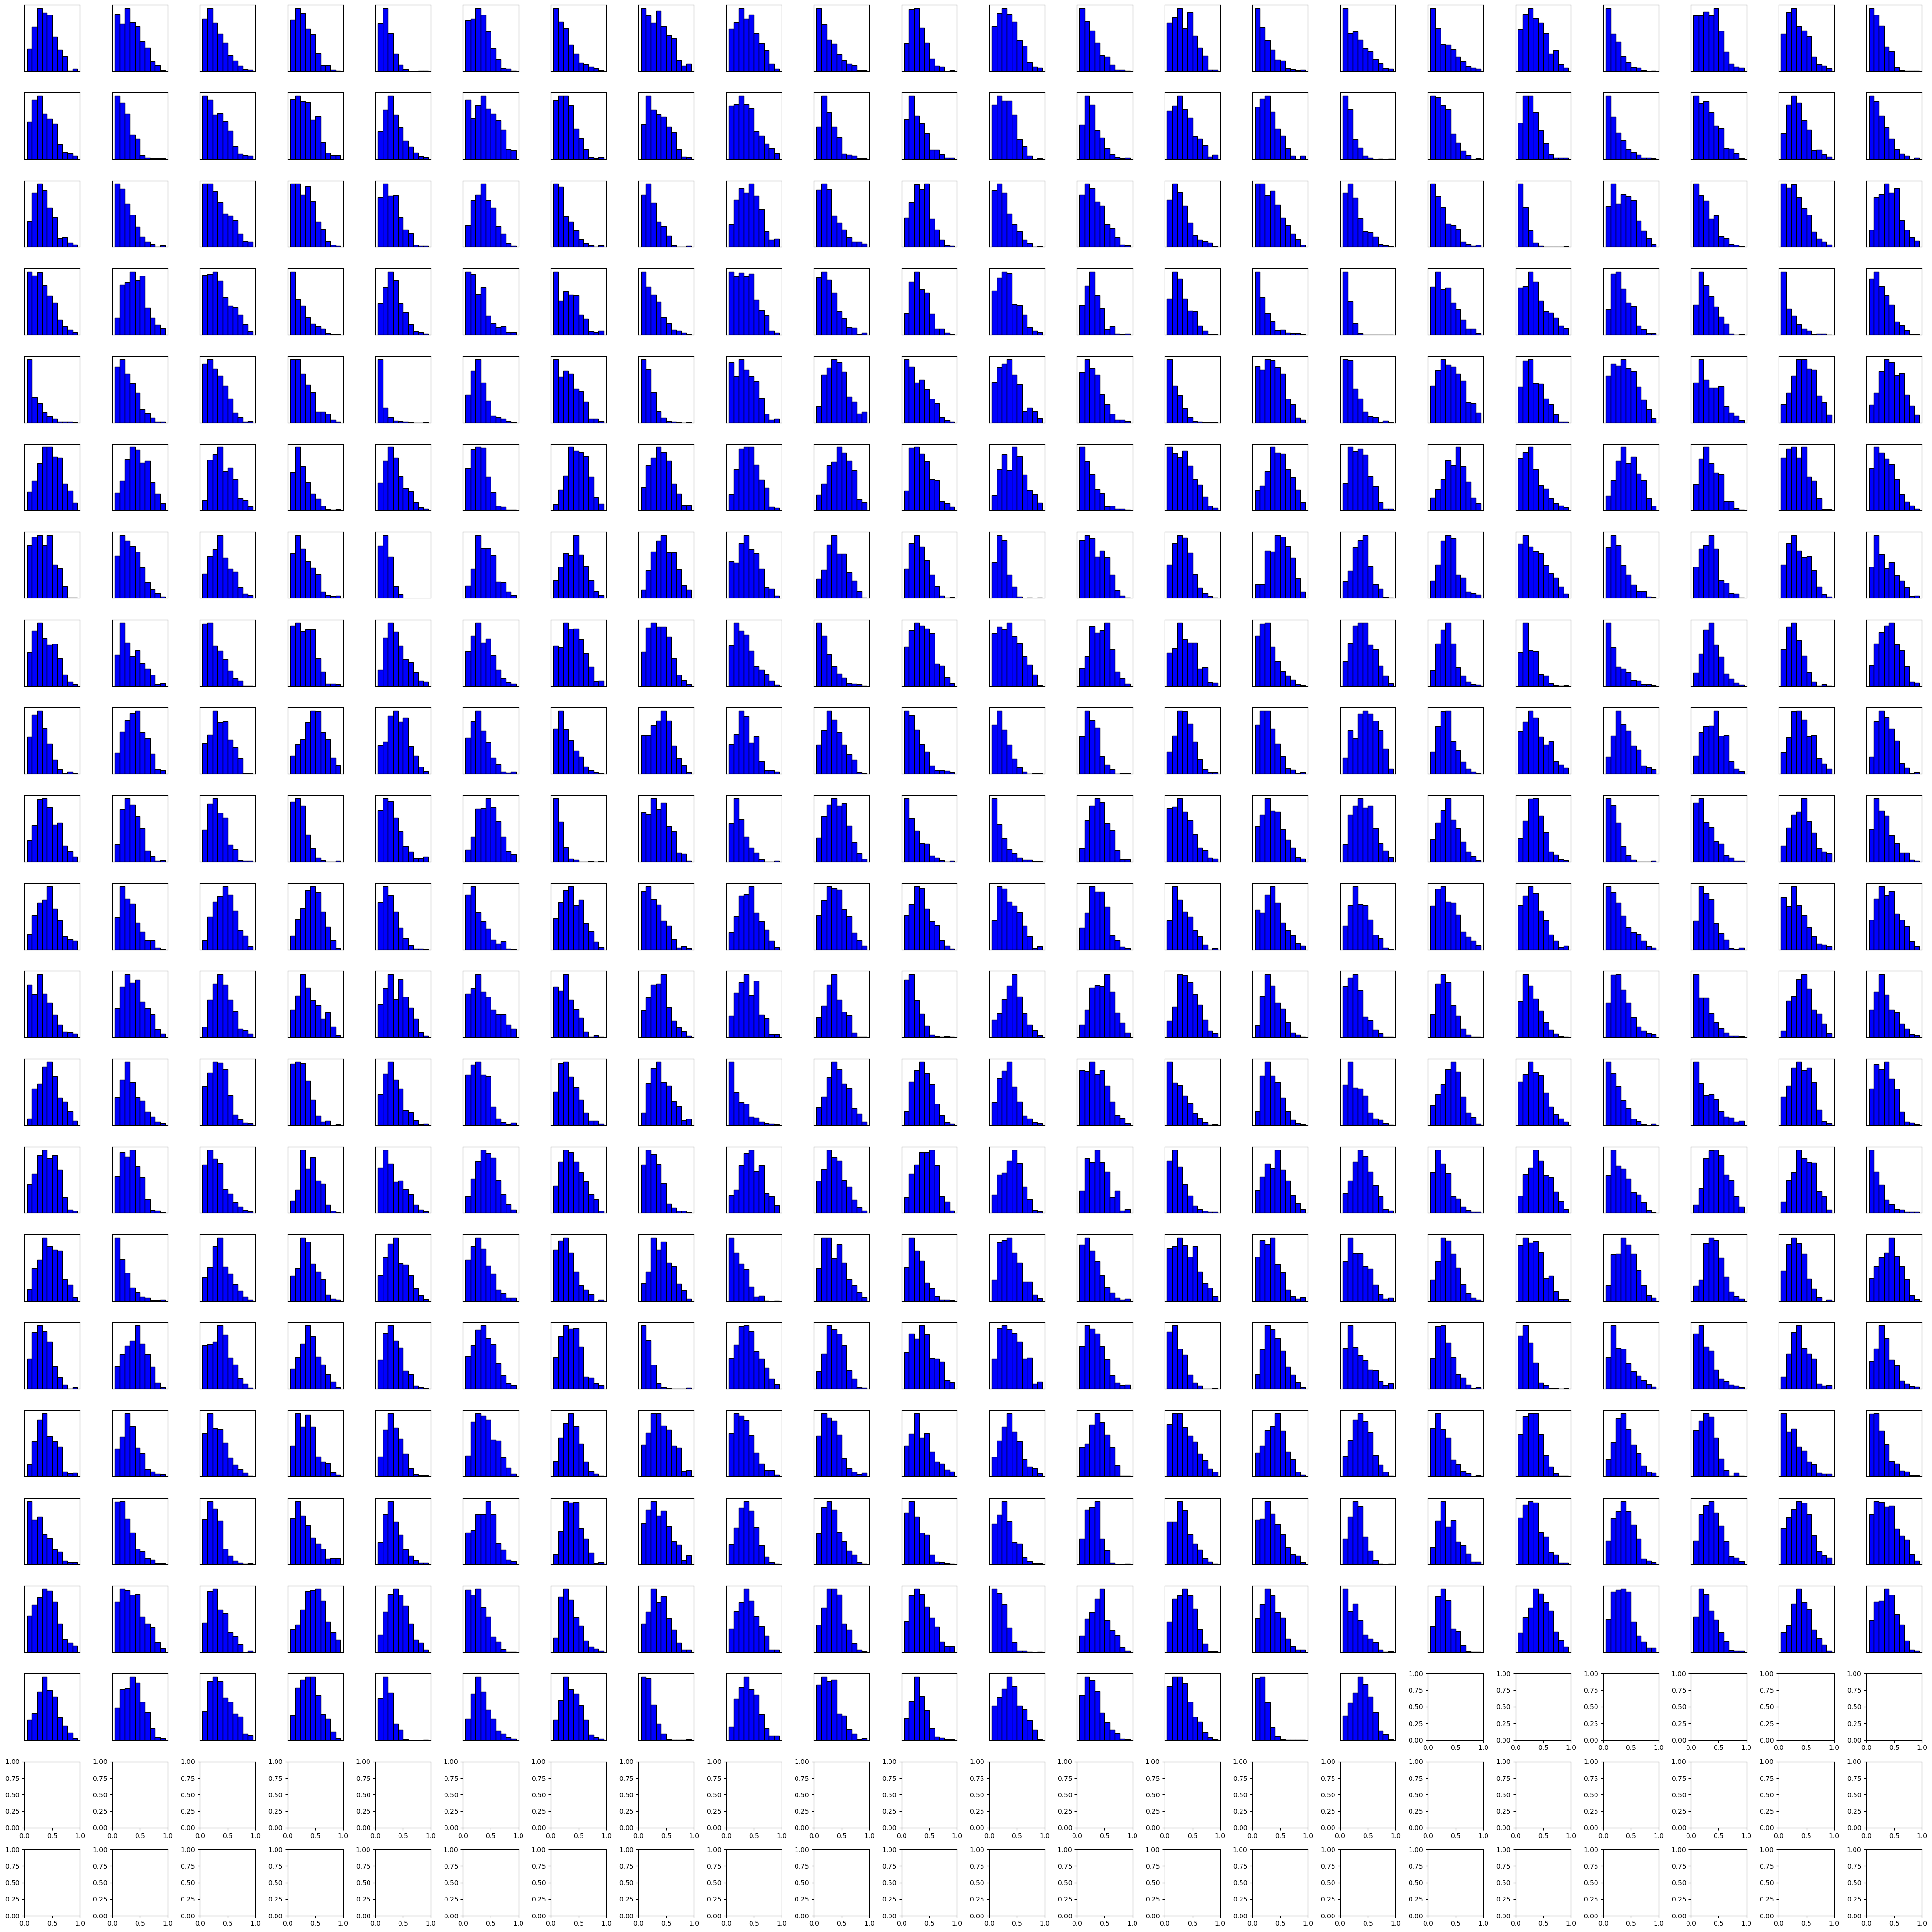

In [ ]:
# Create a 20x20 grid of subplots
fig, axes = plt.subplots(22, 22, figsize=(40, 40))

# Generate random data for each subplot
for i in range(22):
  for j in range(22):
    if (i * 22 + j < 434):
      data = list(COD_LIST_mapping.items())[i * 20 + j]
      axes[i, j].hist(data[1], bins=10, color='blue', edgecolor='black')
      axes[i, j].set_xticks([])
      axes[i, j].set_yticks([])

# Add labels to the outer subplots
# for i in range(22):
#   axes[i, 0].set_ylabel('Frequency')
# for j in range(22):
#   axes[19, j].set_xlabel('X-axis')

# Add a common title
# fig.suptitle('22x22 Histograms', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
for movie in movie_ratings.columns:
  print(f"The average COD for {movie} is {average_COD_mapping[movie]}")

The average COD for The Life of David Gale (2003) is 0.21287799187113615
The average COD for Wing Commander (1999) is 0.18137220060974588
The average COD for Django Unchained (2012) is 0.09600056132714571
The average COD for Alien (1979) is 0.1294569646253784
The average COD for Indiana Jones and the Last Crusade (1989) is 0.09187941913798045
The average COD for Snatch (2000) is 0.1499355593603826
The average COD for Rambo: First Blood Part II (1985) is 0.06233056919837949
The average COD for Fargo (1996) is 0.1504465685629239
The average COD for Let the Right One In (2008) is 0.19308606456593538
The average COD for Black Swan (2010) is 0.058234421124665495
The average COD for King Kong (1976) is 0.09741180476075503
The average COD for The Machinist (2004) is 0.17018491562640597
The average COD for A Nightmare on Elm Street (1984) is 0.12248003230358244
The average COD for Brazil (1985) is 0.21011449097513218
The average COD for The Fast and the Furious (2001) is 0.05607426186977871
Th

## 1.2 Report the average COD values and a table with the 10 movie that are most easily predicted from the ratings of a single other movie.

In [ ]:
sorted_average_COD_listing = list(sorted(average_COD_mapping.items(), key=lambda item: item[1], reverse=True))
table_rows = []
for (movie, average_COD) in sorted_average_COD_listing:
  table_rows.append((movie, average_COD, best_predictor_mapping[movie]))

table_df_10_best = pd.DataFrame(table_rows, columns = ["movie","average_COD","best_predictor"]).head(10)
table_df_10_best = table_df_10_best.set_index("movie")
table_df_10_best

average_COD              best_predictor
movie                                                          
Escape from LA (1996)      0.344879        Runaway Bride (1999)
Moonraker (1979)           0.316437       Escape from LA (1996)
Billy Jack (1971)          0.313400           Sexy Beast (2000)
Sexy Beast (2000)          0.312442     Scent of a Woman (1992)
Erik the Viking (1989)     0.305948                 I.Q. (1994)
The Lookout (2007)         0.302674          The Village (2004)
Crimson Tide (1995)        0.296956            Cable Guy (1996)
Andaz Apna Apna (1994)     0.294969  The Doom Generation (1995)
FeardotCom (2002)          0.286531                  Ran (1985)
Patton (1970)              0.282983          The Village (2004)

## 1.3 Report the average COD values and a table with the 10 movies that are hardest to predict from the ratings of a single other movie.

In [ ]:
sorted_average_COD_listing = list(sorted(average_COD_mapping.items(), key=lambda item: item[1], reverse=False))
table_rows = []
for (movie, average_COD) in sorted_average_COD_listing:
  table_rows.append((movie, average_COD, best_predictor_mapping[movie]))

table_df_10_least = pd.DataFrame(table_rows, columns = ["movie","average_COD","best_predictor"]).head(10)
table_df_10_least = table_df_10_least.set_index("movie")
table_df_10_least

average_COD  \
movie                                                            
Avatar (2009)                                         0.025545   
The Conjuring (2013)                                  0.030845   
Interstellar (2014)                                   0.039403   
Spider-Man (2002)                                     0.047217   
The Avengers (2012)                                   0.049374   
Pirates of the Caribbean: Dead Man's Chest (2006)     0.053017   
The Fast and the Furious (2001)                       0.056074   
The Matrix Revolutions (2003)                         0.058122   
Black Swan (2010)                                     0.058234   
Shrek 2 (2004)                                        0.061940   

                                                                                    best_predictor  
movie                                                                                               
Avatar (2009)                                                                      Bad Boys (1995)  
The Conjuring (2013)                                                           The Exorcist (1973)  
Interstellar (2014)                                                                  Torque (2004)  
Spider-Man (2002)                                                                    Batman (1989)  
The Avengers (2012)                                              Captain America: Civil War (2016)  
Pirates of the Caribbean: Dead Man's Chest (2006)  Pirates of the Caribbean: At World's End (2007)  
The Fast and the Furious (2001)                                       Gone in Sixty Seconds (2000)  
The Matrix Revolutions (2003)                                           The Matrix Reloaded (2003)  
Black Swan (2010)                                                                 Moonraker (1979)  
Shrek 2 (2004)                                                                        Shrek (2001)

# Problem 2
For the 10 movies that are best and least well predicted from the ratings of a single other movie (so 20 in total), build multiple regression models that include gender identity (column 475), sibship status (column 476) and social viewing preferences (column 477) as additional predictors (in addition to the best predicting movie from question 1). Comment on how R^2 has changed relative to the answers in question 1. Please include a figure with a scatterplot where the old COD (for the simple linear regression models from the previous question) is on the x-axis and the new R^2 (for the new multiple regression models) is on the y-axis.


## 2.0 Utility Function

In [ ]:
# Fit Multiple Linear Regression Model to a single movie given column 475~477 and the best predictor from problem 1
def fit_multi_regression_model(raw_data, table_information, movie):
  model = LinearRegression()
  predictor_columns = [table_information.loc[movie,"best_predictor"],*raw_data.columns[474:477]]
  data = raw_data[[movie,*predictor_columns]].dropna()
  predictors = data[predictor_columns]
  label = data[movie]

  model.fit(predictors, label)
  predictions = model.predict(predictors)
  R2 = r2_score(label, predictions)

  res = {}
  res["movie"] = movie
  res["old_COD"] = table_information.loc[movie, "average_COD"]
  res["new_COD"] = R2
  return res

## 2.1 Fit Multiple Linear Regression Model to the 10 best predicted movies

In [ ]:
data_rows = []
for movie in table_df_10_best.index:
  res = fit_multi_regression_model(raw_data, table_df_10_best, movie)
  data_rows.append((res["movie"], res["old_COD"], res["new_COD"]))

table_new_df_COD_10_best = pd.DataFrame(data_rows, columns=["movie","old_COD", "new_COD"])
table_new_df_COD_10_best = table_new_df_COD_10_best.set_index("movie")
table_new_df_COD_10_best

old_COD   new_COD
movie                                     
Escape from LA (1996)   0.344879  0.732205
Moonraker (1979)        0.316437  0.638274
Billy Jack (1971)       0.313400  0.638461
Sexy Beast (2000)       0.312442  0.677596
Erik the Viking (1989)  0.305948  0.706803
The Lookout (2007)      0.302674  0.696941
Crimson Tide (1995)     0.296956  0.728535
Andaz Apna Apna (1994)  0.294969  0.694848
FeardotCom (2002)       0.286531  0.751242
Patton (1970)           0.282983  0.768436

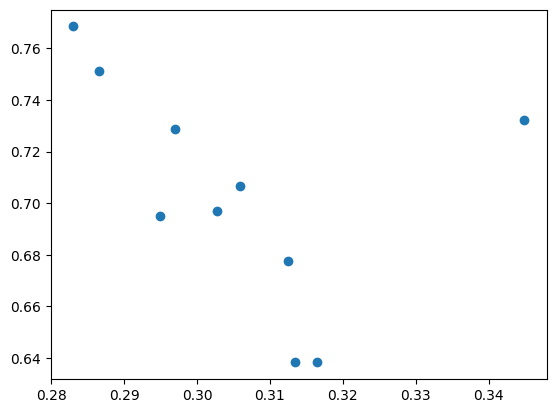

In [ ]:
plt.scatter(table_new_df_COD_10_best["old_COD"], table_new_df_COD_10_best["new_COD"])

## 2.2 Fit Multiple Linear Regression Model to the 10 least predicted movies

In [ ]:
data_rows = []
for movie in table_df_10_least.index:
  res = fit_multi_regression_model(raw_data, table_df_10_least, movie)
  data_rows.append((res["movie"], res["old_COD"], res["new_COD"]))

table_new_df_COD_10_least = pd.DataFrame(data_rows, columns=["movie","old_COD", "new_COD"])
table_new_df_COD_10_least = table_new_df_COD_10_least.set_index("movie")
table_new_df_COD_10_least

old_COD   new_COD
movie                                                                
Avatar (2009)                                      0.025545  0.167469
The Conjuring (2013)                               0.030845  0.369116
Interstellar (2014)                                0.039403  0.260169
Spider-Man (2002)                                  0.047217  0.265738
The Avengers (2012)                                0.049374  0.433000
Pirates of the Caribbean: Dead Man's Chest (2006)  0.053017  0.525276
The Fast and the Furious (2001)                    0.056074  0.267020
The Matrix Revolutions (2003)                      0.058122  0.396051
Black Swan (2010)                                  0.058234  0.237812
Shrek 2 (2004)                                     0.061940  0.527765

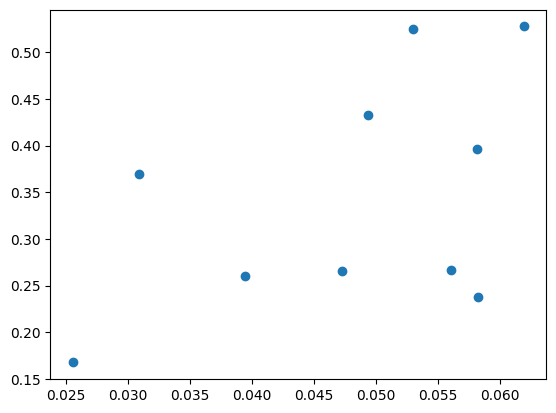

In [ ]:
plt.scatter(table_new_df_COD_10_least["old_COD"], table_new_df_COD_10_least["new_COD"])

We find that as we add more predictors to our linear regression model, the R^2 metric increases, which makes sense since the more feature we add into our model, the highee the R^2 is.


Based on the scatter plot, there is no correlation between old COD and new COD.

# Problem 3
Pick 30 movies in the middle of the COD range, as identified by question 1 (that were not used in question 2). Now build a regularized regression model with the ratings from 10 other movies (picked randomly, or deliberately by you) as an input. Please use ridge regression, and make sure to do suitable hyperparameter tuning. Also make sure to report the RMSE for each of these 30 movies in a table, after doing an 80/20 train/test split. Comment on the hyperparameters you use and betas you find by doing so.

## 3.0 Utility Functions

In [ ]:
import random
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Randomly pick 30 movies from the middle based on COD range
def pick_30_movies(sorted_average_COD_listing):
  length = len(sorted_average_COD_listing)
  sampled_movies_COD = random.choices(sorted_average_COD_listing[length // 3: length // 3 * 2], k =30)
  return sampled_movies_COD

# Build a ridge regression model for a single movie, with alpha being the hyperparameter of the ridge model
def build_regression_model(movie_ratings, movie, model_type, alpha):
  # Sample 10 movies to be the predictors
  np.random.seed(42)

  # Just to ensure that the movie that we choose for different target movie is close to each other
  # Each target movie's predictor should have large overlaps
  choice_list = np.array(list(set(movie_ratings.columns) - set([movie])))
  random_indices = np.random.randint(0, 399, size=(10,))
  predictor_columns = list(choice_list[random_indices])
  data = movie_ratings[[movie, *predictor_columns]].dropna()
  predictors = data[predictor_columns]
  label = data[movie]

  if model_type == "ridge":
    model = Ridge(alpha = alpha)
  elif model_type == "lasso":
    model = Ridge(alpha = alpha)

  # Train-Test Split
  X_train, X_test, y_train, y_test = train_test_split(predictors, label, test_size=0.2, random_state=42)

  # Fit the model
  model.fit(X_train, y_train)
  y_hat = model.predict(X_test)

  RMSE = np.sqrt(mean_squared_error(y_hat, y_test))

  return predictor_columns, RMSE, np.round(model.coef_,2)


# Construct a table for 30 movies at alpha
def report_RMSE_for_30_movies(movie_ratings, sampled_movies, model_type, alpha = 0.1):
  data_rows = []
  for movie in sampled_movies:
    predictors, RMSE, betas = build_regression_model(movie_ratings, movie, model_type, alpha)
    data_rows.append((movie, predictors, RMSE, alpha, betas))

  res = pd.DataFrame(data_rows, columns = ["movie", "predictor", "RMSE", "alpha", "betas"])
  return res

def grid_search_on_alpha(movie_ratings, sampled_movies, model_type, alpha_list):


  RMSE_history = []
  best_alpha = None
  best_RMSE = np.inf

  for alpha in alpha_list:
    table_res = report_RMSE_for_30_movies(movie_ratings, sampled_movies, model_type, alpha)
    average_RMSE = table_res["RMSE"].mean()
    if average_RMSE < best_RMSE:
      best_alpha = alpha
      best_RMSE = average_RMSE
    RMSE_history.append(average_RMSE)

  return best_alpha, RMSE_history

## 3.1 Pick 30 movies from the middle COD range

In [ ]:
sorted_average_COD_listing = list(sorted(average_COD_mapping.items(), key=lambda item: item[1], reverse=True))
sampled_movies_COD = pick_30_movies(sorted_average_COD_listing)
sampled_movies = list(map(lambda item: item[0],sampled_movies_COD))

## 3.2 Fit Ridge Regression Model
Report the RMSE for each movie

In [ ]:
table_res = report_RMSE_for_30_movies(movie_ratings, sampled_movies, "ridge", 1000)
table_res

movie  \
0                           Spirited Away (2001)   
1                            The Prestige (2006)   
2                                Anaconda (1997)   
3                                  Torque (2004)   
4                                   Split (2016)   
5          The Nightmare Before Christmas (1993)   
6                           28 Days Later (2002)   
7   Austin Powers: The Spy Who Shagged Me (1999)   
8                                   Se7en (1995)   
9                Night of the Living Dead (1968)   
10  Austin Powers: The Spy Who Shagged Me (1999)   
11                           Donnie Darko (2001)   
12                       Meet the Parents (2000)   
13                                 Grease (1978)   
14                           Pearl Harbor (2001)   
15                       Just Like Heaven (2005)   
16                           Men in Black (1997)   
17                    Lost in Translation (2003)   
18                         The Green Mile (1999)   
19                   My Father and My Son (2005)   
20           There's Something About Mary (1998)   
21                                 Grease (1978)   
22                              The Visit (2015)   
23                          Arachnophobia (1990)   
24  Austin Powers: The Spy Who Shagged Me (1999)   
25                                  Se7en (1995)   
26                       Girl Interrupted (1999)   
27                     Look Who's Talking (1989)   
28                 The Godfather: Part II (1974)   
29                          Baby Geniuses (1999)   

                                            predictor      RMSE  alpha  \
0   [Barb Wire (1996), King Kong (1976), Divine Se...  1.473300   1000   
1   [Honey (2003), King Kong (1976), Angels in the...  0.798226   1000   
2   [Honey (2003), King Kong (1976), Angels in the...  0.782901   1000   
3   [Honey (2003), King Kong (1976), Divine Secret...  0.709588   1000   
4   [Honey (2003), King Kong (1976), Divine Secret...  1.393346   1000   
5   [Honey (2003), King Kong (1976), Angels in the...  1.110754   1000   
6   [Honey (2003), King Kong (1976), Divine Secret...  1.669155   1000   
7   [Honey (2003), King Kong (1976), Divine Secret...  1.337228   1000   
8   [Honey (2003), King Kong (1976), Divine Secret...  1.395665   1000   
9   [Honey (2003), The Big Lebowski (1998), Angels...  1.230649   1000   
10  [Honey (2003), King Kong (1976), Divine Secret...  1.337228   1000   
11  [Honey (2003), King Kong (1976), Divine Secret...  1.663342   1000   
12  [Honey (2003), King Kong (1976), Divine Secret...  1.079540   1000   
13  [Honey (2003), King Kong (1976), Divine Secret...  1.530488   1000   
14  [Barb Wire (1996), King Kong (1976), Divine Se...  0.861265   1000   
15  [Honey (2003), The Big Lebowski (1998), Angels...  0.825473   1000   
16  [Honey (2003), King Kong (1976), Divine Secret...  1.046807   1000   
17  [Honey (2003), King Kong (1976), Divine Secret...  1.179437   1000   
18  [Honey (2003), King Kong (1976), Angels in the...  1.132024   1000   
19  [Honey (2003), King Kong (1976), Divine Secret...  1.162783   1000   
20  [Honey (2003), King Kong (1976), Angels in the...  1.164949   1000   
21  [Honey (2003), King Kong (1976), Divine Secret...  1.530488   1000   
22  [Honey (2003), King Kong (1976), Divine Secret...  1.512225   1000   
23  [Honey (2003), King Kong (1976), Angels in the...  1.204163   1000   
24  [Honey (2003), King Kong (1976), Divine Secret...  1.337228   1000   
25  [Honey (2003), King Kong (1976), Divine Secret...  1.395665   1000   
26  [Honey (2003), King Kong (1976), Divine Secret...  1.088069   1000   
27  [Honey (2003), King Kong (1976), Divine Secret...  1.261344   1000   
28  [Barb Wire (1996), King Kong (1976), Divine Se...  1.361539   1000   
29  [Honey (2003), King Kong (1976), Divine Secret...  1.356037   1000   

                                                betas  
0   [0.01, 0.01, 0.0, 0.01, 0.01, 0.02, 0.01, 0.02...  
1   [0.0, 0.0, 0.01, 0.

## 3.3 Grid Search on multiple alpha


Text(0.5, 1.0, 'Grid Search Results')

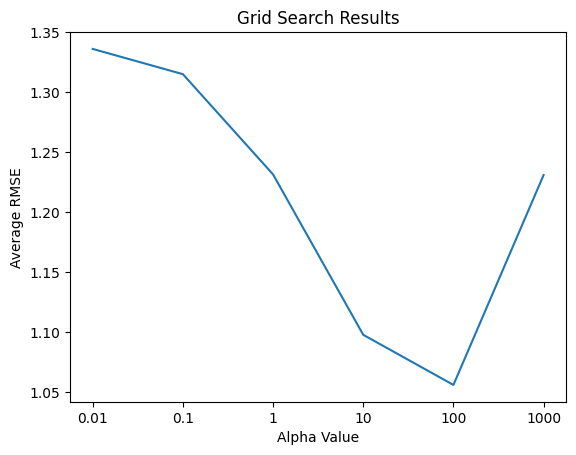

In [ ]:
alpha_list = [0.01, 0.1, 1, 10, 100, 1000]
best_alpha, RMSE_history = grid_search_on_alpha(movie_ratings, sampled_movies, "ridge", alpha_list)
plt.plot(np.arange(len(RMSE_history)),RMSE_history)
plt.xticks(np.arange(len(RMSE_history)), alpha_list)
plt.xlabel("Alpha Value")
plt.ylabel("Average RMSE")
plt.title("Grid Search Results")

Based on the plot we see that when we choose the regularization coefficient to be 10, we get on average the least RMSE across all 30 movies.

# Problem 4
 Repeat question 3) with LASSO regression. Again, make sure to comment on the hyperparameters you use and betas you find by doing so.


## 4.1 Pick 30 movies from the middle COD range

In [ ]:
sampled_movies_COD = pick_30_movies(sorted_average_COD_listing)
sampled_movies = list(map(lambda item: item[0],sampled_movies_COD))

## 4.2 Fit Lasso Regression Model
Report the RMSE for each movie


In [ ]:
table_res = report_RMSE_for_30_movies(movie_ratings, sampled_movies, "lasso", 1000)
table_res

movie  \
0   Star Wars: Episode V - The Empire Strikes Back...   
1                                        North (1994)   
2                     The Shawshank Redemption (1994)   
3                                Arachnophobia (1990)   
4                                      X-Men 2 (2003)   
5                The Bridges of Madison County (1995)   
6                                    The Visit (2015)   
7                           Dances with Wolves (1990)   
8                           Dances with Wolves (1990)   
9                                28 Days Later (2002)   
10                                        Jaws (1975)   
11                            Girl Interrupted (1999)   
12                                  Braveheart (1995)   
13                                      Oldboy (2003)   
14                                   The Thing (1982)   
15                                 Stand By Me (1986)   
16               The Bridges of Madison County (1995)   
17                        The Three Musketeers (1993)   
18                                Blade Runner (1982)   
19                             The Sixth Sense (1999)   
20                             Change of Habit (1969)   
21                                  Braveheart (1995)   
22                             Sixteen Candles (1984)   
23                              Mrs. Doubtfire (1993)   
24                                Beetle Juice (1988)   
25                                    The Mist (2007)   
26                         Blues Brothers 2000 (1998)   
27                                     X-Men 2 (2003)   
28                    The Shawshank Redemption (1994)   
29                  The King of Marvin Gardens (1972)   

                                            predictor      RMSE  alpha  \
0   [Honey (2003), King Kong (1976), Divine Secret...  1.312609   1000   
1   [Honey (2003), The Big Lebowski (1998), Angels...  0.707477   1000   
2   [Barb Wire (1996), King Kong (1976), Divine Se...  1.085718   1000   
3   [Honey (2003), King Kong (1976), Angels in the...  1.204163   1000   
4   [Honey (2003), King Kong (1976), Divine Secret...  1.422522   1000   
5   [Honey (2003), King Kong (1976), Angels in the...  1.384028   1000   
6   [Honey (2003), King Kong (1976), Divine Secret...  1.512225   1000   
7   [Barb Wire (1996), King Kong (1976), Divine Se...  1.528711   1000   
8   [Barb Wire (1996), King Kong (1976), Divine Se...  1.528711   1000   
9   [Honey (2003), King Kong (1976), Divine Secret...  1.669155   1000   
10  [Honey (2003), King Kong (1976), Angels in the...  1.297486   1000   
11  [Honey (2003), King Kong (1976), Divine Secret...  1.088069   1000   
12  [Honey (2003), King Kong (1976), Divine Secret...  1.121155   1000   
13  [Honey (2003), King Kong (1976), Angels in the...  1.021749   1000   
14  [Honey (2003), King Kong (1976), Angels in the...  1.209675   1000   
15  [Honey (2003), King Kong (1976), Divine Secret...  1.462228   1000   
16  [Honey (2003), King Kong (1976), Angels in the...  1.384028   1000   
17  [Honey (2003), King Kong (1976), Divine Secret...  1.117404   1000   
18  [Honey (2003), King Kong (1976), Divine Secret...  1.437235   1000   
19  [Honey (2003), King Kong (1976), Angels in the...  1.341042   1000   
20  [Honey (2003), King Kong (1976), Divine Secret...  1.324626   1000   
21  [Honey (2003), King Kong (1976), Divine Secret...  1.121155   1000   
22  [Honey (2003), The Big Lebowski (1998), Angels...  1.130929   1000   
23  [Honey (2003), King Kong (1976), Angels in the...  0.492208   1000   
24  [Honey (2003), King Kong (1976), Divine Secret...  1.458086   1000   
25  [Barb Wire (1996), King Kong (1976), Divine Se...  1.530756   1000   
26  [Barb Wire (1996), King Kong (1976), Divine Se...  0.914397   1000   
27  [Honey (2003), King Kong (1976), Divine Secret...  1.422522   1000   
28  [Barb Wire (1996), King Kong (1976), Divine Se...  1.085718   1000   
29  [Honey (2003), King Kong (1976), Divine Secret...  1.005

## 4.3 Fit Ridge Regression Model
Report the RMSE for each movie

Text(0.5, 1.0, 'Grid Search Results')

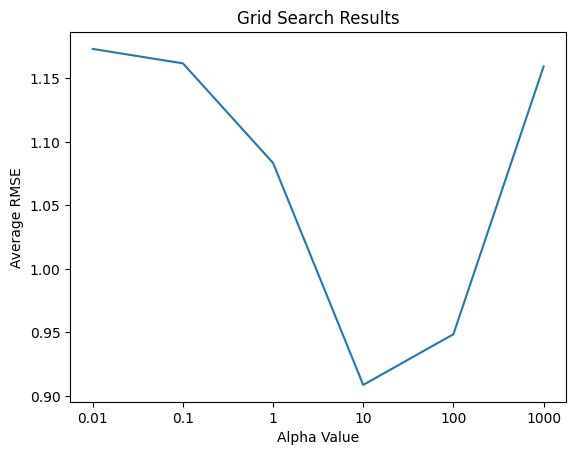

In [ ]:
alpha_list = [0.01, 0.1, 1, 10, 100, 1000]
best_alpha, RMSE_history = grid_search_on_alpha(movie_ratings, sampled_movies, "lasso", alpha_list)
plt.plot(np.arange(len(RMSE_history)),RMSE_history)
plt.xticks(np.arange(len(RMSE_history)), alpha_list)
plt.xlabel("Alpha Value")
plt.ylabel("Average RMSE")
plt.title("Grid Search Results")

Based on the plot we see that when we choose the regularization coefficient to be 10, we get on average the least RMSE across all 30 movies.

# Problem 5
Compute the average movie enjoyment for each user (using only real, non-imputed data). Use these averages as the predictor variable X in a logistic regression model. Sort the movies order of increasing rating (also using only real, non-imputed data). Now pick the 4 movies in the middle of the score range as your target movie. For each of them, do a media split (now using the imputed data) of ratings to code movies above the median rating with the Y label 1 (= enjoyed) and movies below the median with the label 0 (= not enjoyed). For each of these movies, build a logistic regression model (using X to predict Y), show figures with the outcomes and report the betas as well as the AUC values. Comment on the quality of your models. Make sure to use cross-validation methods to avoid overfitting.

## 5.0 Utility Functions

In [ ]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score

# Randomly pick 4 movies from the middle based on average ratings
def pick_n_movies(average_ratings, n):
  length = len(average_ratings)
  sampled_movies = random.choices(average_ratings[length // 3: length // 3 * 2], k = n)
  return sampled_movies

def fit_logistic_regression_for_single_movie_CV(movie_ratings, target):
  average_enjoyment = np.nan_to_num(movie_ratings.mean(axis=1).to_numpy(), nan=0).reshape(-1,1)

  # Impute with median
  movie_ratings[target] = movie_ratings[[target]].fillna(movie_ratings[target].median())

  # Median Split
  median = movie_ratings[target].median()
  # print("median", median)
  movie_ratings[movie_ratings[target] <= median] = 0
  movie_ratings[movie_ratings[target] > median] = 1

  model = LogisticRegression()
  X = average_enjoyment
  y = movie_ratings[target]

  cv_results = cross_validate(model, X, y, cv=10, scoring=make_scorer(roc_auc_score, needs_proba=True), return_estimator = True, n_jobs = 3)
  return X,y,cv_results

def select_best_models_and_generate_comments(cv_result, movie, X, y):
  best_betas = cv_result["estimator"][np.argmax(cv_result["test_score"])].coef_
  best_intercept = cv_result["estimator"][np.argmax(cv_result["test_score"])].intercept_
  print(f"The parameters for the best logistic regression model for the movie {movie} is {[best_intercept[0], best_betas.item()]}")
  print(f"The best AUC score is {cv_result['test_score'][np.argmax(cv_result['test_score'])]}")
  print("The regression line is shown as follows:")
  draw_decision_boundary([best_intercept[0], best_betas.item()],X, y)


def draw_decision_boundary(coeffs, X, y):
  plt.scatter(X, y, cmap="viridis")
  plt.plot(X, coeffs[1] * X)
  plt.show()

## 5.1 Sample 4 movies

In [ ]:
movie_ratings_mapping = list(sorted(list(dict(movie_ratings.mean(axis=0)).items()), key=lambda item: item[1] , reverse = False))
sampled_movies = pick_n_movies(movie_ratings_mapping, 4)

## 5.2 Fit Logistic Regression Model and Comment

The parameters for the best logistic regression model for the movie The Blair Witch Project (1999) is [-2.4525058930008314, 0.18526483199163235]
The best AUC score is 0.6703869047619048
The regression line is shown as follows:


<ipython-input-6-305c5366e695>:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, y, cmap="viridis")


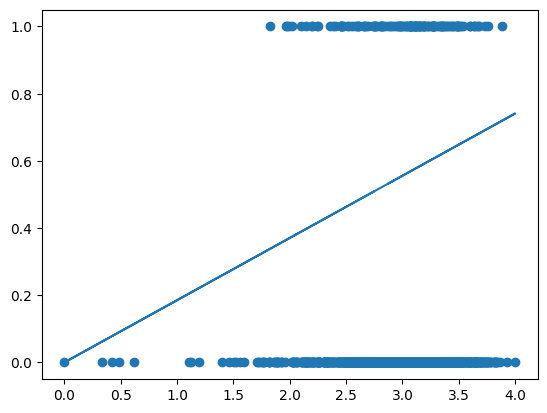

The parameters for the best logistic regression model for the movie The Blue Lagoon (1980) is [-3.234453732095635, 0.23256418410419827]
The best AUC score is 0.6398514851485149
The regression line is shown as follows:


<ipython-input-6-305c5366e695>:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, y, cmap="viridis")


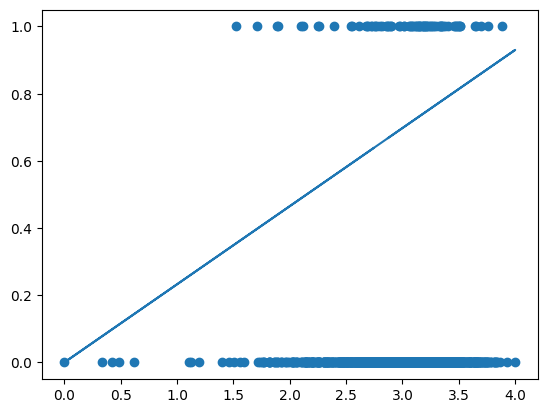

The parameters for the best logistic regression model for the movie Who's Afraid of Virginia Woolf (1966) is [-4.592027011190055, 0.4746157829859437]
The best AUC score is 0.7666666666666666
The regression line is shown as follows:


<ipython-input-6-305c5366e695>:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, y, cmap="viridis")


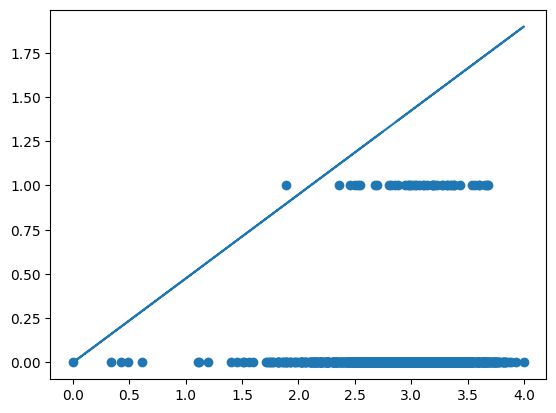

The parameters for the best logistic regression model for the movie 28 Days Later (2002) is [-3.282581128652201, 0.2863593991803279]
The best AUC score is 0.7238723872387238
The regression line is shown as follows:


<ipython-input-6-305c5366e695>:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, y, cmap="viridis")


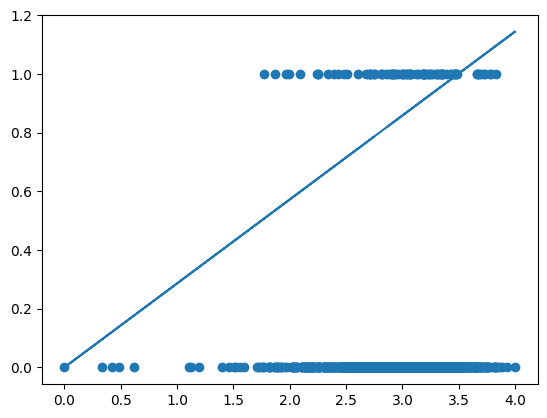

In [ ]:
cv_result_list = []
for (movie,_) in sampled_movies:
  X,y,cv_result = fit_logistic_regression_for_single_movie_CV(movie_ratings.copy(), movie)
  select_best_models_and_generate_comments(cv_result, movie, X.reshape(-1), y.to_numpy())
  cv_result_list.append((movie,cv_result))

In [ ]:
table_rows = []
for (movie, cv_result) in cv_result_list:
  best_betas = cv_result["estimator"][np.argmax(cv_result["test_score"])].coef_
  best_intercept = cv_result["estimator"][np.argmax(cv_result["test_score"])].intercept_
  best_test_score = cv_result["test_score"][np.argmax(cv_result["test_score"])]
  table_rows.append((movie, [best_intercept[0], best_betas.item()], best_test_score))
table_df_cv_logit = pd.DataFrame(table_rows,columns=["movie","best betas","best_AUC_score"])
table_df_cv_logit

movie  \
0         The Blair Witch Project (1999)   
1                 The Blue Lagoon (1980)   
2  Who's Afraid of Virginia Woolf (1966)   
3                   28 Days Later (2002)   

                                   best betas  best_AUC_score  
0  [-2.4525058930008314, 0.18526483199163235]        0.670387  
1   [-3.234453732095635, 0.23256418410419827]        0.639851  
2    [-4.592027011190055, 0.4746157829859437]        0.766667  
3    [-3.282581128652201, 0.2863593991803279]        0.723872

In [ ]:
movie_ratings

The Life of David Gale (2003)  Wing Commander (1999)  \
0                               NaN                    NaN   
1                               NaN                    NaN   
2                               NaN                    NaN   
3                               NaN                    NaN   
4                               NaN                    NaN   
...                             ...                    ...   
1092                            NaN                    NaN   
1093                            3.0                    4.0   
1094                            NaN                    NaN   
1095                            NaN                    NaN   
1096                            NaN                    NaN   

      Django Unchained (2012)  Alien (1979)  \
0                         4.0           NaN   
1                         1.5           NaN   
2                         NaN           NaN   
3                         2.0           NaN   
4                         3.5           NaN   
...                       ...           ...   
1092                      NaN           NaN   
1093                      NaN           NaN   
1094                      NaN           NaN   
1095                      NaN           NaN   
1096                      4.0           NaN   

      Indiana Jones and the Last Crusade (1989)  Snatch (2000)  \
0                                           3.0            NaN   
1                                           NaN            NaN   
2                                           NaN            NaN   
3                                           3.0            NaN   
4                                           0.5            NaN   
...                                         ...            ...   
1092                                        3.5            NaN   
1093                                        4.0            4.0   
1094                                        NaN            NaN   
1095                                        NaN            NaN   
1096                                        2.5            NaN   

      Rambo: First Blood Part II (1985)  Fargo (1996)  \
0                                   NaN           NaN   
1                                   NaN           NaN   
2                                   NaN           NaN   
3                                   NaN           NaN   
4                                   0.5           1.0   
...                                 ...           ...   
1092                                NaN           NaN   
1093                                2.5           NaN   
1094                                NaN           3.5   
1095                                NaN           NaN   
1096                                NaN           3.0   

      Let the Right One In (2008)  Black Swan (2010)  ...  X-Men 2 (2003)  \
0                             NaN                NaN  ...             NaN   
1                             NaN                NaN  ...             NaN   
2                             NaN                NaN  ...             NaN   
3                             NaN                4.0  ...             NaN   
4                             NaN                0.0  ...             2.5   
...                           ...                ...  ...             ...   
1092                          NaN                NaN  ...             NaN   
1093                          3.5                3.5  ...             4.0   
1094                          NaN                NaN  ...             NaN   
1095                          NaN                NaN  ...             NaN   
1096                          NaN                3.5  ...             NaN   

      The Usual Suspects (1995)  The Mask (1994)  Jaws (1975)  \
0                           NaN              NaN          4.0   
1                           NaN              NaN          NaN   
2                           NaN              NaN          NaN   
3                           3.0  

# Problem 6
Extra Credit: Use machine learning methods of your choice to tell us something interesting and true about the movies in this dataset that is not already covered by the questions above [for an additional 5% of the grade score].


## Clustering using Gender Identity and Only Child status.

### Create two dimensional pair and drop pairs that contain any NaN value.

In [ ]:
# raw_data
gender = raw_data.iloc[:, 474].unique().tolist()  # Note: Python is zero-indexed
print(gender)
child = raw_data.iloc[:, 475].unique().tolist()  # Note: Python is zero-indexed
print(child)

[1.0, 2.0, nan, 3.0]
[0, 1, -1]


In [ ]:
# Extract the 475th and 476th columns as pairs
column_pair_list = raw_data.iloc[:, [474, 475]].dropna().values.tolist()
print(len(column_pair_list))

1073


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

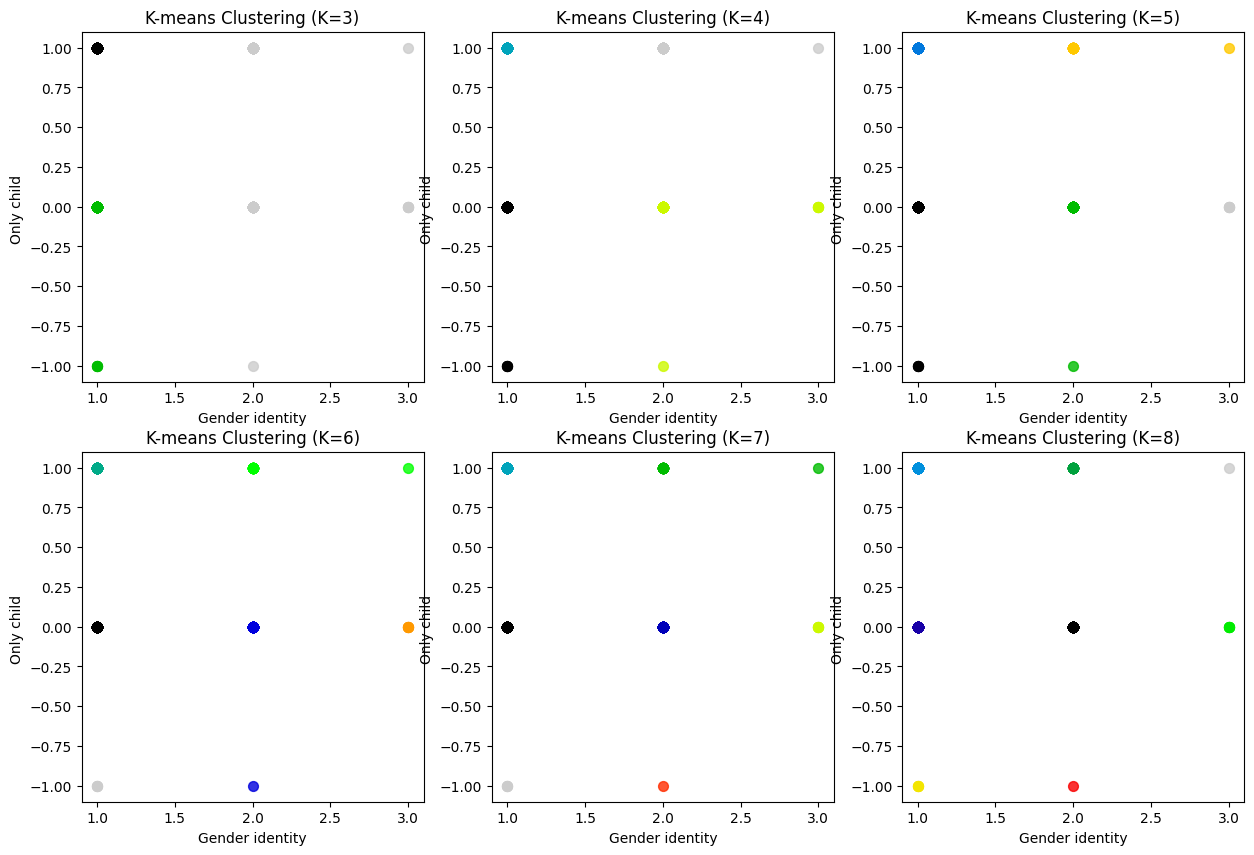

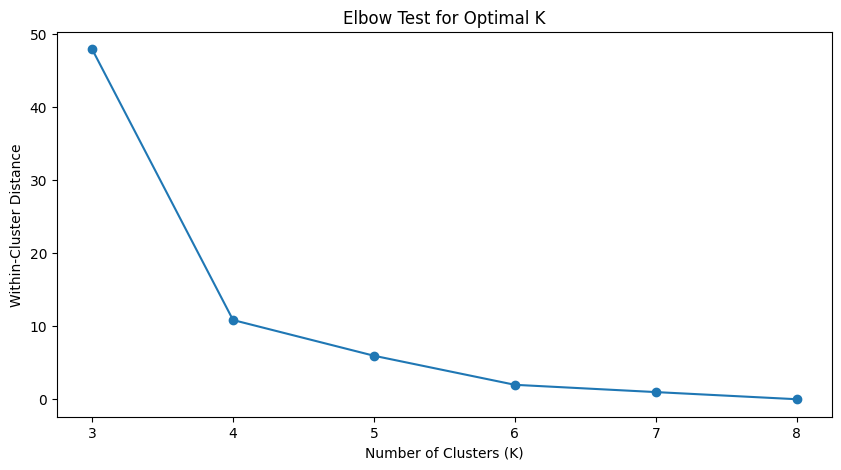

In [ ]:
# Convert the list of pairs to a NumPy array
data = np.array(column_pair_list)

# Specify the range of clusters (3 to 9)
cluster_range = range(3, 9)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# List to store within-cluster distances
within_cluster_distances = []

for i, n_clusters in enumerate(cluster_range):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)

    # Get cluster labels
    cluster_labels = kmeans.labels_

    # Visualize the clusters
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_clusters))
    for cluster_label, color in zip(range(n_clusters), colors):
        cluster_points = data[cluster_labels == cluster_label]
        axes[i].scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], s=50, alpha=0.8)

    axes[i].set_title(f'K-means Clustering (K={n_clusters})')
    axes[i].set_xlabel('Gender identity')
    axes[i].set_ylabel('Only child ')

    # Measure within-cluster distances
    within_cluster_distance = kmeans.inertia_
    within_cluster_distances.append(within_cluster_distance)

# Elbow test visualization
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, within_cluster_distances, marker='o')
plt.title('Elbow Test for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Distance')
plt.show()